# Neural Network - Digital Recognition

The subject today is digit recognition using neural networks. More precisely, the task is to train a neural network so that it finds the digit in a given image of handwritten digit.
The first step is to split the MNIST dataset into a training set, a validation set, and a test set. During the training phase, the neural network is trained on the training set. Still during the training phase, the recognition score of the neural network is checked on a subset of the training set and on the validation set in order to detect potential overfitting. During the test set, the true classification score of the fully-connected neural network is computed on the test set.

In [1]:
# Needed packages
import os
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import tensorflow as tf
import tools.tools as tls
from tqdm import tqdm

/Users/louisgiron/Desktop/ENSAE - Mastère spé/Reseaux de neurones/devoir_cours/tools/tools.py:6: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('Qt5Agg')


## I - Process the data and visualisation

### Import data

In [2]:
path = os.getcwd() + '/mnist/data/'

train_img = np.load(path+'training_images.npy')
train_labels = np.load(path+'training_labels.npy')

valid_img = np.load(path+'validation_images.npy')
valid_labels = np.load(path+'validation_labels.npy')

test_img = np.load(path+'test_images.npy')
test_labels = np.load(path+'test_labels.npy')

### Process the data

In [3]:
# img
train_img_new = train_img.reshape(train_img.shape[0],
                                  train_img.shape[1]**2).astype('uint64')
valid_img_new = valid_img.reshape(valid_img.shape[0],
                                  valid_img.shape[1]**2).astype('uint64')
test_img_new = test_img.reshape(test_img.shape[0],
                                test_img.shape[1]**2).astype('uint64')

# label
train_lab_new = np.array([np.argmax(train_labels[y])
                          for y in range(len(train_labels))])
valid_lab_new = np.array([np.argmax(valid_labels[y])
                          for y in range(len(valid_labels))])
test_lab_new = np.array([np.argmax(valid_labels[y])
                         for y in range(len(valid_labels))])

### Random permutation of the train set (for the training phase of the neural network)

In [4]:
permut_index = np.random.permutation(train_img_new.shape[0])

train_img = train_img[permut_index, :, :]
train_img_new = train_img_new[permut_index, :]
train_labels = train_labels[permut_index, :]
train_lab_new = train_lab_new[permut_index]

### Visualisation (exported in the folder 'img_observation')

In [5]:
# Visualisation
def visualize(path, name, X, y, nb_img=36):
    """Allows to vizualise 36 img and the labels"""
    vector_viz = [rd.randint(0, len(X)-1) for y in np.arange(nb_img)]
    # Img
    nb_vertically = int(np.sqrt(nb_img))
    name_img_out = path+'visualize_img' + '_' + str(name) + '.png'
    tls.visualize_grayscale_images(X[vector_viz, :, :, :],
                                   nb_vertically, name_img_out)

    # Labels
    name_lab_out = path+'visualize_labels' + '_' + str(name)
    labels = train_lab_new[vector_viz]
    labels = labels.reshape((nb_vertically, nb_vertically))

    file = open(name_lab_out, "w")
    labels_str = ''
    for line in labels:
        for elt in line:
            labels_str = labels_str + str(elt) + ' '
        labels_str = labels_str + '\n'
    file.write(labels_str)
    file.close()
    print('Visualisation exported')


path = os.getcwd() + '/img_observation/'
X = train_img
y = train_lab_new
visualize(path, 'obs', X, y, nb_img=36)

Visualisation exported


## II - Basic Neural Network

import the model within the file 'NeuralNetwork.py'

### Training the neural network

In [6]:
# Import the model
from NeuralNetwork import neural_net_model

In [7]:
# Input data
nb_images = train_img_new.shape[0]
nb_input = train_img_new.shape[1]
batch_size = 1000
nb_hidden = 16
nb_classes = 10
learning_rate = 0.5
nb_epoch = 20

The following function is used in order to define batches during the training (it is the equivalent of the next batch function of tf)

In [8]:
def get_batch_idx(i, batch_size, nb_images):
    # Input
    max_batch_size = int(nb_images/batch_size)
    j = i % max_batch_size
    return np.arange(j*batch_size, (j+1)*batch_size)

In [9]:
# Initialisation
X = tf.placeholder(tf.float32, [None, nb_input])
Y = tf.placeholder(tf.float32, [None, nb_classes])

p = neural_net_model(X, nb_input, batch_size, nb_hidden, nb_classes,
                     learning_rate)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(p),
                                              reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)

correct_pred = tf.equal(tf.argmax(p, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

acc_train = []
loss_train = []

In [10]:
# Training
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())

    try:
        saver.restore(sess, 'mnist_predictions.ckpt')
    except Exception:
        pass

    # train the model mini batch with 100 elements, for 1K times
    for epoch in tqdm(range(nb_epoch)):

        for i in range(batch_size):
            batch_index = get_batch_idx(i, batch_size, nb_images)
            batch_x, batch_y = (train_img_new[batch_index, :],
                                train_labels[batch_index])
            sess.run([train_step], feed_dict={X: batch_x, Y: batch_y})

        # Accuracy and cross entropy - Training phase
        loss, acc = sess.run([cross_entropy, accuracy],
                             feed_dict={X: valid_img_new, Y: valid_labels})
        loss_train.append(loss)
        acc_train.append(acc)
        print("\nEpoch", str(epoch), "Loss :", str(loss),
              "Accuracy :", str(acc))

    # Test
    # evaluate the accuracy of the model
    test_accuracy = sess.run(accuracy, feed_dict={X: test_img_new,
                                                  Y: test_labels})
    print("\nAccuracy on test set:", test_accuracy)

    # pred
    pred = sess.run(p, feed_dict={X: test_img_new, Y: test_labels})
    pred = np.array([np.argmax(pred[y]) for y in range(len(pred))])
    labels = np.array([np.argmax(test_labels[y])
                       for y in range(len(test_labels))])

    print("\nErrors (%):", np.sum(labels != pred)/len(pred), '%')

    # Save the model
    '''if input('Save model ? [Y/N]') == 'Y':
        import os
        saver.save(sess, os.getcwd() +
                   '/nn_saved_sessions/mnist_predictions.ckpt')
        print('Model Saved')'''

    # Close the session
    sess.close()

  5%|▌         | 1/20 [00:03<01:00,  3.18s/it]


Epoch 0 Loss : 0.7032309 Accuracy : 0.784


 10%|█         | 2/20 [00:06<00:56,  3.14s/it]


Epoch 1 Loss : 0.5632114 Accuracy : 0.83


 15%|█▌        | 3/20 [00:09<00:52,  3.11s/it]


Epoch 2 Loss : 0.48669207 Accuracy : 0.864


 20%|██        | 4/20 [00:12<00:49,  3.10s/it]


Epoch 3 Loss : 0.48724446 Accuracy : 0.857


 25%|██▌       | 5/20 [00:15<00:46,  3.09s/it]


Epoch 4 Loss : 0.4298973 Accuracy : 0.868


 30%|███       | 6/20 [00:18<00:43,  3.08s/it]


Epoch 5 Loss : 0.47212836 Accuracy : 0.858


 35%|███▌      | 7/20 [00:21<00:39,  3.07s/it]


Epoch 6 Loss : 0.4207762 Accuracy : 0.878


 40%|████      | 8/20 [00:24<00:36,  3.06s/it]


Epoch 7 Loss : 0.40833053 Accuracy : 0.87


 45%|████▌     | 9/20 [00:27<00:33,  3.06s/it]


Epoch 8 Loss : 0.4314237 Accuracy : 0.883


 50%|█████     | 10/20 [00:30<00:30,  3.06s/it]


Epoch 9 Loss : 0.40475735 Accuracy : 0.893


 55%|█████▌    | 11/20 [00:33<00:27,  3.06s/it]


Epoch 10 Loss : 0.38988772 Accuracy : 0.885


 60%|██████    | 12/20 [00:36<00:24,  3.06s/it]


Epoch 11 Loss : 0.35153353 Accuracy : 0.895


 65%|██████▌   | 13/20 [00:39<00:21,  3.05s/it]


Epoch 12 Loss : 0.37468654 Accuracy : 0.895


 70%|███████   | 14/20 [00:42<00:18,  3.05s/it]


Epoch 13 Loss : 0.38662815 Accuracy : 0.876


 75%|███████▌  | 15/20 [00:45<00:15,  3.05s/it]


Epoch 14 Loss : 0.39788365 Accuracy : 0.89


 80%|████████  | 16/20 [00:48<00:12,  3.05s/it]


Epoch 15 Loss : 0.3840801 Accuracy : 0.891


 85%|████████▌ | 17/20 [00:52<00:09,  3.05s/it]


Epoch 16 Loss : 0.36137858 Accuracy : 0.903


 90%|█████████ | 18/20 [00:55<00:06,  3.05s/it]


Epoch 17 Loss : 0.33917475 Accuracy : 0.899


 95%|█████████▌| 19/20 [00:58<00:03,  3.06s/it]


Epoch 18 Loss : 0.3464671 Accuracy : 0.9


100%|██████████| 20/20 [01:01<00:00,  3.06s/it]


Epoch 19 Loss : 0.36720476 Accuracy : 0.898

Accuracy on test set: 0.9003

Errors (%): 0.0997 %


### Visualisation

#### Accuracy

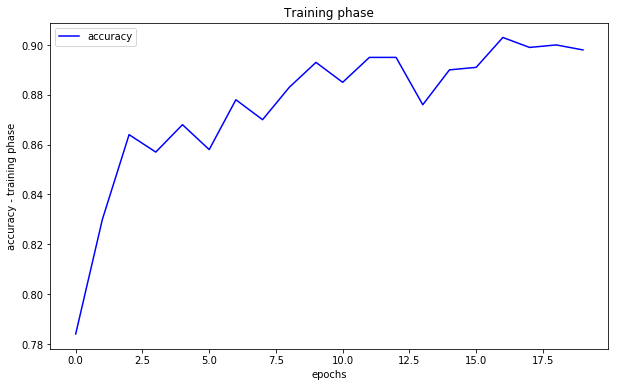

In [11]:
# Visualisation of the accuracy
plt.figure(figsize=(10, 6))
plt.plot(np.arange(nb_epoch), acc_train, label='accuracy', color='blue')
plt.title('Training phase')
plt.ylabel('accuracy - training phase')
plt.xlabel('epochs')
plt.legend(loc='best')
plt.show()

#### Cross entrepoy

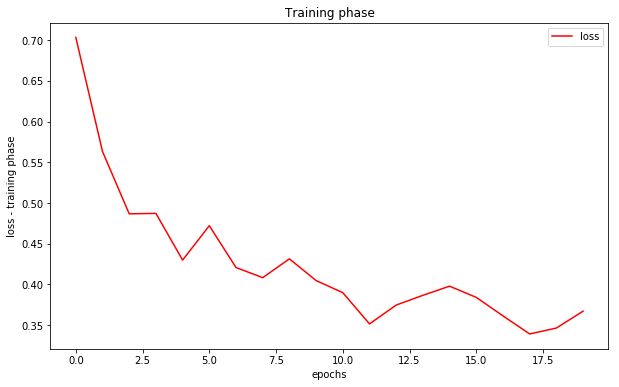

In [12]:
# Visualisation of the loss
plt.figure(figsize=(10, 6))
plt.plot(np.arange(nb_epoch), loss_train, label='loss', color='red')
plt.title('Training phase')
plt.ylabel('loss - training phase')
plt.xlabel('epochs')
plt.legend(loc='best')
plt.show()

### Observations

## III - Evolved Neural Network

In [13]:
from NeuralNetwork import neural_net_model_evol

In [14]:
# Input data
nb_images = train_img_new.shape[0]
nb_input = train_img_new.shape[1]
batch_size = 1000
nb_hidden1 = 64
nb_hidden2 = 64
nb_classes = 10
nb_epoch = 20

# Drop out level
prob_1 = 0.7
prob_2 = 0.7

The following function is used in order to define batches during the training (it is the equivalent of the next batch function of tf)

In [15]:
def get_batch_idx(i, batch_size, nb_images):
    # Input
    max_batch_size = int(nb_images/batch_size)
    j = i % max_batch_size
    return np.arange(j*batch_size, (j+1)*batch_size)

In [16]:
# Initialisation
X = tf.placeholder(tf.float32, [None, nb_input])
Y = tf.placeholder(tf.float32, [None, nb_classes])
keep_prob_1 = tf.placeholder(tf.float32)
keep_prob_2 = tf.placeholder(tf.float32)

p = neural_net_model_evol(X, nb_input, nb_hidden1, nb_hidden2, nb_classes,
                          keep_prob_1, keep_prob_2)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(p),
                                              reduction_indices=[1]))

correct_pred = tf.equal(tf.argmax(p, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

acc_train = []
loss_train = []
learn_rate = []

We then define a piecewise constant for learning rate in order not to have a constant value through the training phase

In [17]:
# Piecewise constant
min_lr = 0.1
max_lr = 0.5
nb_values = nb_epoch

global_step = tf.Variable(0, trainable=False)
boundaries = list(np.linspace(batch_size,
                              batch_size*nb_epoch, nb_values,
                              dtype=np.int32)[:-1])
values = list(np.round(np.linspace(max_lr, min_lr, nb_values), 2))
learning_rate_pc = tf.train.piecewise_constant(global_step, boundaries, values)

j = 0
# Passing global_step to minimize() will increment it at each step.
learning_step_pc = tf.train.GradientDescentOptimizer(learning_rate_pc).minimize(cross_entropy,
                                                                 global_step=global_step)

In [18]:
# Training
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())

    try:
        saver.restore(sess, 'mnist_predictions.ckpt')
    except Exception:
        pass

    # train the model mini batch with 100 elements, for 1K times
    for epoch in tqdm(range(nb_epoch)):

        for i in range(batch_size):
            # Update learning rate
            l_rate = sess.run(learning_rate_pc, {global_step: j})
            j += 1

            batch_index = get_batch_idx(i, batch_size, nb_images)
            batch_x, batch_y = (train_img_new[batch_index, :],
                                train_labels[batch_index])
            sess.run([learning_step_pc], feed_dict={X: batch_x, Y: batch_y,
                                                    keep_prob_1: prob_1,
                                                    keep_prob_2: prob_2})

        # Accuracy and cross entropy - Training phase
        loss, acc = sess.run([cross_entropy, accuracy],
                             feed_dict={X: valid_img_new, Y: valid_labels,
                                        keep_prob_1: 1.0,
                                        keep_prob_2: 1.0})
        loss_train.append(loss)
        acc_train.append(acc)
        learn_rate.append(l_rate)
        print("\nEpoch", str(epoch), "Loss :", str(loss),
              "Accuracy :", str(acc), "Learning rate:", l_rate)

    # Test
    # evaluate the accuracy of the model
    test_accuracy = sess.run(accuracy, feed_dict={X: test_img_new,
                                                  Y: test_labels,
                                                  keep_prob_1: 1.0,
                                                  keep_prob_2: 1.0})
    print("\nAccuracy on test set:", test_accuracy)

    # pred
    pred = sess.run(p, feed_dict={X: test_img_new, Y: test_labels,
                                  keep_prob_1: 1.0, keep_prob_2: 1.0})
    pred = np.array([np.argmax(pred[y]) for y in range(len(pred))])
    labels = np.array([np.argmax(test_labels[y])
                       for y in range(len(test_labels))])

    print("\nErrors (%):", np.sum(labels != pred)/len(pred)*100, '%')

    # Save the model
    '''if input('Save model ? [Y/N]') == 'Y':
        import os
        saver.save(sess, os.getcwd() +
                   '/nn_saved_sessions/mnist_predictions.ckpt')
        print('Model Saved')'''

    # Close the session
    sess.close()

  5%|▌         | 1/20 [00:07<02:16,  7.18s/it]


Epoch 0 Loss : 0.8470795 Accuracy : 0.738 Learning rate: 0.5


 10%|█         | 2/20 [00:13<02:06,  7.04s/it]


Epoch 1 Loss : 0.63434535 Accuracy : 0.796 Learning rate: 0.48


 15%|█▌        | 3/20 [00:20<01:58,  6.95s/it]


Epoch 2 Loss : 0.5491786 Accuracy : 0.851 Learning rate: 0.46


 20%|██        | 4/20 [00:27<01:50,  6.89s/it]


Epoch 3 Loss : 0.49640504 Accuracy : 0.853 Learning rate: 0.44


 25%|██▌       | 5/20 [00:34<01:42,  6.85s/it]


Epoch 4 Loss : 0.46356007 Accuracy : 0.862 Learning rate: 0.42


 30%|███       | 6/20 [00:40<01:35,  6.85s/it]


Epoch 5 Loss : 0.42818928 Accuracy : 0.875 Learning rate: 0.39


 35%|███▌      | 7/20 [00:47<01:28,  6.84s/it]


Epoch 6 Loss : 0.41328505 Accuracy : 0.88 Learning rate: 0.37


 40%|████      | 8/20 [00:54<01:21,  6.83s/it]


Epoch 7 Loss : 0.38541183 Accuracy : 0.889 Learning rate: 0.35


 45%|████▌     | 9/20 [01:01<01:15,  6.83s/it]


Epoch 8 Loss : 0.36615044 Accuracy : 0.891 Learning rate: 0.33


 50%|█████     | 10/20 [01:08<01:08,  6.82s/it]


Epoch 9 Loss : 0.35910955 Accuracy : 0.903 Learning rate: 0.31


 55%|█████▌    | 11/20 [01:15<01:01,  6.82s/it]


Epoch 10 Loss : 0.35482463 Accuracy : 0.903 Learning rate: 0.29


 60%|██████    | 12/20 [01:21<00:54,  6.82s/it]


Epoch 11 Loss : 0.33443573 Accuracy : 0.901 Learning rate: 0.27


 65%|██████▌   | 13/20 [01:28<00:47,  6.83s/it]


Epoch 12 Loss : 0.32248607 Accuracy : 0.906 Learning rate: 0.25


 70%|███████   | 14/20 [01:35<00:40,  6.83s/it]


Epoch 13 Loss : 0.32905436 Accuracy : 0.902 Learning rate: 0.23


 75%|███████▌  | 15/20 [01:42<00:34,  6.83s/it]


Epoch 14 Loss : 0.30733797 Accuracy : 0.912 Learning rate: 0.21


 80%|████████  | 16/20 [01:49<00:27,  6.84s/it]


Epoch 15 Loss : 0.32136384 Accuracy : 0.9 Learning rate: 0.18


 85%|████████▌ | 17/20 [01:56<00:20,  6.84s/it]


Epoch 16 Loss : 0.3175103 Accuracy : 0.895 Learning rate: 0.16


 90%|█████████ | 18/20 [02:02<00:13,  6.84s/it]


Epoch 17 Loss : 0.31429937 Accuracy : 0.903 Learning rate: 0.14


 95%|█████████▌| 19/20 [02:09<00:06,  6.85s/it]


Epoch 18 Loss : 0.31030193 Accuracy : 0.905 Learning rate: 0.12


100%|██████████| 20/20 [02:16<00:00,  6.82s/it]


Epoch 19 Loss : 0.30323657 Accuracy : 0.906 Learning rate: 0.1

Accuracy on test set: 0.9084

Errors (%): 9.16 %


### Visualisation

#### Accuracy

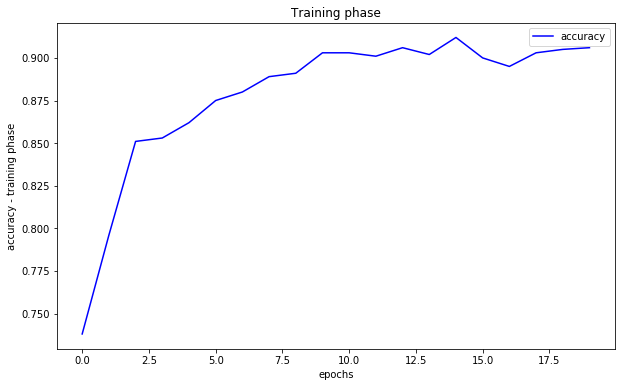

In [19]:
# Visualisation of the accuracy
plt.figure(figsize=(10, 6))
plt.plot(np.arange(nb_epoch), acc_train, label='accuracy', color='blue')
plt.title('Training phase')
plt.ylabel('accuracy - training phase')
plt.xlabel('epochs')
plt.legend(loc='best')
plt.show()

#### Loss

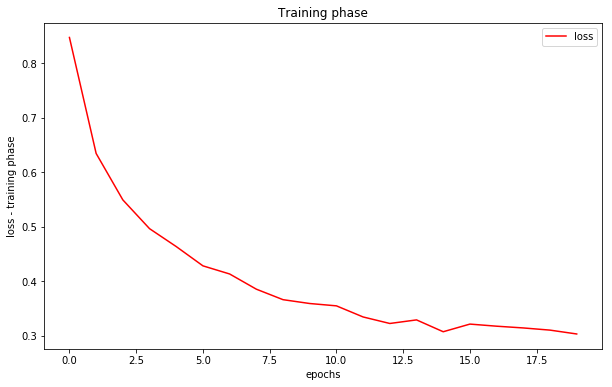

In [20]:
# Visualisation of the loss
plt.figure(figsize=(10, 6))
plt.plot(np.arange(nb_epoch), loss_train, label='loss', color='red')
plt.title('Training phase')
plt.ylabel('loss - training phase')
plt.xlabel('epochs')
plt.legend(loc='best')
plt.show()

#### Learning rate

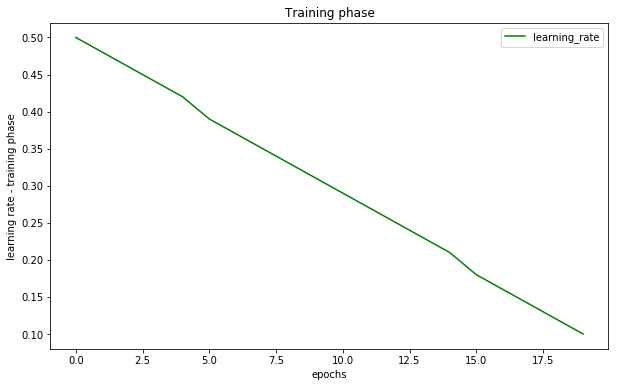

In [21]:
# Visualisation of the learning rate
plt.figure(figsize=(10, 6))
plt.plot(np.arange(nb_epoch), learn_rate, label='learning_rate', color='green')
plt.title('Training phase')
plt.ylabel('learning rate - training phase')
plt.xlabel('epochs')
plt.legend(loc='best')
plt.show()

### Observations

### We will now use a exponential decay for the learning rate

In [22]:
acc_train = []
loss_train = []
learn_rate = []

In [23]:
# Exponential decay of the learning rate
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.7
learning_rate_ed = tf.train.exponential_decay(starter_learning_rate,
                                              global_step, batch_size, 0.69,
                                              staircase=True)
j = 0
# Passing global_step to minimize() will increment it at each step.
learning_step_ed = tf.train.GradientDescentOptimizer(learning_rate_ed).minimize(cross_entropy,
                                                   global_step=global_step)

In [24]:
# initialize variables and session
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())

    try:
        saver.restore(sess, 'mnist_predictions.ckpt')
    except Exception:
        pass

    # train the model mini batch with 100 elements, for 1K times
    for epoch in tqdm(range(nb_epoch)):

        for i in range(batch_size):
            # Update learning rate
            l_rate = sess.run(learning_rate_ed, {global_step: j})
            j += 1

            batch_index = get_batch_idx(i, batch_size, nb_images)
            batch_x, batch_y = (train_img_new[batch_index, :],
                                train_labels[batch_index])
            sess.run([learning_step_ed], feed_dict={X: batch_x, Y: batch_y,
                                                    keep_prob_1: prob_1,
                                                    keep_prob_2: prob_2})

        # Accuracy and cross entropy - Training phase
        loss, acc = sess.run([cross_entropy, accuracy],
                             feed_dict={X: valid_img_new, Y: valid_labels,
                                        keep_prob_1: 1.0,
                                        keep_prob_2: 1.0})
        loss_train.append(loss)
        acc_train.append(acc)
        learn_rate.append(l_rate)
        print("\nEpoch", str(epoch), "Loss :", str(loss),
              "Accuracy :", str(acc), "Learning rate:", l_rate)

    # Test
    # evaluate the accuracy of the model
    test_accuracy = sess.run(accuracy, feed_dict={X: test_img_new,
                                                  Y: test_labels,
                                                  keep_prob_1: 1.0,
                                                  keep_prob_2: 1.0})
    print("\nAccuracy on test set:", test_accuracy)

    # pred
    pred = sess.run(p, feed_dict={X: test_img_new, Y: test_labels,
                                  keep_prob_1: 1.0, keep_prob_2: 1.0})
    pred = np.array([np.argmax(pred[y]) for y in range(len(pred))])
    labels = np.array([np.argmax(test_labels[y])
                       for y in range(len(test_labels))])

    print("\nErrors (%):", np.sum(labels != pred)/len(pred)*100, '%')

    # Save the model
    '''if input('Save model ? [Y/N]') == 'Y':
        import os
        saver.save(sess, os.getcwd() +
                   '/nn_saved_sessions/mnist_predictions.ckpt')
        print('Model Saved')'''

    # Close the session
    sess.close()

  5%|▌         | 1/20 [00:06<02:00,  6.32s/it]


Epoch 0 Loss : 0.7738734 Accuracy : 0.755 Learning rate: 0.7


 10%|█         | 2/20 [00:12<01:53,  6.31s/it]


Epoch 1 Loss : 0.6102331 Accuracy : 0.813 Learning rate: 0.48299998


 15%|█▌        | 3/20 [00:18<01:47,  6.31s/it]


Epoch 2 Loss : 0.53096193 Accuracy : 0.842 Learning rate: 0.33326998


 20%|██        | 4/20 [00:25<01:40,  6.29s/it]


Epoch 3 Loss : 0.5096934 Accuracy : 0.84 Learning rate: 0.2299563


 25%|██▌       | 5/20 [00:31<01:34,  6.28s/it]


Epoch 4 Loss : 0.47992632 Accuracy : 0.85 Learning rate: 0.15866984


 30%|███       | 6/20 [00:37<01:27,  6.26s/it]


Epoch 5 Loss : 0.4493919 Accuracy : 0.86 Learning rate: 0.1094822


 35%|███▌      | 7/20 [00:43<01:21,  6.27s/it]


Epoch 6 Loss : 0.45056218 Accuracy : 0.86 Learning rate: 0.07554271


 40%|████      | 8/20 [00:50<01:15,  6.26s/it]


Epoch 7 Loss : 0.44852012 Accuracy : 0.862 Learning rate: 0.05212447


 45%|████▌     | 9/20 [00:56<01:08,  6.25s/it]


Epoch 8 Loss : 0.43534836 Accuracy : 0.86 Learning rate: 0.035965886


 50%|█████     | 10/20 [01:02<01:02,  6.25s/it]


Epoch 9 Loss : 0.44109002 Accuracy : 0.862 Learning rate: 0.02481646


 55%|█████▌    | 11/20 [01:08<00:56,  6.26s/it]


Epoch 10 Loss : 0.43823832 Accuracy : 0.861 Learning rate: 0.017123358


 60%|██████    | 12/20 [01:15<00:50,  6.26s/it]


Epoch 11 Loss : 0.4377058 Accuracy : 0.864 Learning rate: 0.011815117


 65%|██████▌   | 13/20 [01:21<00:43,  6.26s/it]


Epoch 12 Loss : 0.4366819 Accuracy : 0.865 Learning rate: 0.008152431


 70%|███████   | 14/20 [01:27<00:37,  6.25s/it]


Epoch 13 Loss : 0.43645126 Accuracy : 0.865 Learning rate: 0.0056251767


 75%|███████▌  | 15/20 [01:33<00:31,  6.25s/it]


Epoch 14 Loss : 0.43559048 Accuracy : 0.865 Learning rate: 0.0038813723


 80%|████████  | 16/20 [01:40<00:24,  6.25s/it]


Epoch 15 Loss : 0.43627593 Accuracy : 0.865 Learning rate: 0.0026781466


 85%|████████▌ | 17/20 [01:46<00:18,  6.25s/it]


Epoch 16 Loss : 0.43530372 Accuracy : 0.865 Learning rate: 0.0018479213


 90%|█████████ | 18/20 [01:52<00:12,  6.24s/it]


Epoch 17 Loss : 0.4351424 Accuracy : 0.865 Learning rate: 0.0012750656


 95%|█████████▌| 19/20 [01:58<00:06,  6.24s/it]


Epoch 18 Loss : 0.43516794 Accuracy : 0.865 Learning rate: 0.0008797953


100%|██████████| 20/20 [02:05<00:00,  6.25s/it]


Epoch 19 Loss : 0.4350232 Accuracy : 0.865 Learning rate: 0.00060705876

Accuracy on test set: 0.8762

Errors (%): 12.379999999999999 %


### Visualisation

#### Accuracy

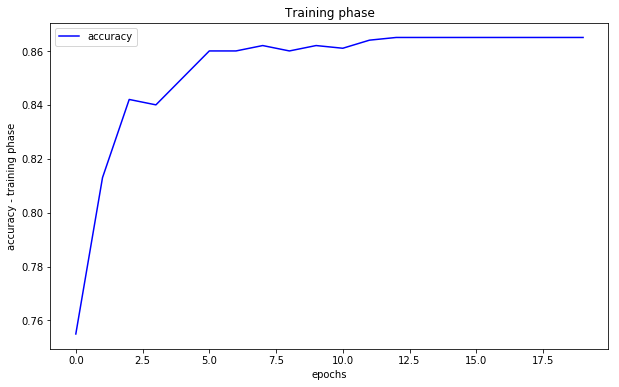

In [25]:
# Visualisation of the accuracy
plt.figure(figsize=(10, 6))
plt.plot(np.arange(nb_epoch), acc_train, label='accuracy', color='blue')
plt.title('Training phase')
plt.ylabel('accuracy - training phase')
plt.xlabel('epochs')
plt.legend(loc='best')
plt.show()

#### Loss

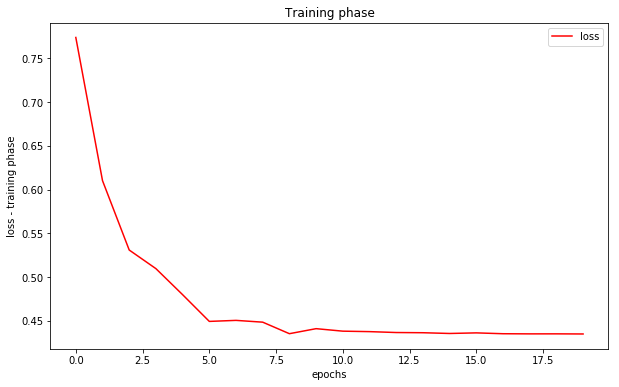

In [26]:
# Visualisation of the loss
plt.figure(figsize=(10, 6))
plt.plot(np.arange(nb_epoch), loss_train, label='loss', color='red')
plt.title('Training phase')
plt.ylabel('loss - training phase')
plt.xlabel('epochs')
plt.legend(loc='best')
plt.show()

#### Learning rate

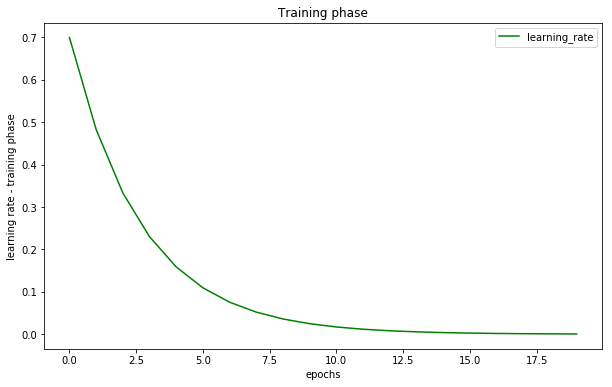

In [27]:
# Visualisation of the learning rate
plt.figure(figsize=(10, 6))
plt.plot(np.arange(nb_epoch), learn_rate, label='learning_rate', color='green')
plt.title('Training phase')
plt.ylabel('learning rate - training phase')
plt.xlabel('epochs')
plt.legend(loc='best')
plt.show()

### Observations